In [1]:
# initial imports
import pandas as pd
import os
import numpy as np
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import shap
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from joblib import dump
import seaborn as sns

In [2]:
# initial csv load
df = pd.read_csv(r'/Users/ianforrest/Downloads/Stats - Sheet1 (2).csv')

In [3]:
# check dataframe
df.head()

,Player,Pos,Age,Ht(in),Wt(lbs),MPG,FG%,3P%,FT%,PPG,...,APG,SPG,BPG,TPG,2018-19 SAL,PG?,SG?,SF?,PF?,C?
0,Aaron Gordon,PF,23,81,220,33.8,0.449,0.349,0.731,16.0,...,3.7,0.7,0.7,2.1,"$21,590,909",0,0,0,1,0
1,Aaron Holiday,PG,22,73,185,12.9,0.401,0.339,0.820,5.9,...,1.7,0.4,0.3,0.8,"$1,911,960",1,0,0,0,0
2,Abdel Nader,SF,25,78,225,11.4,0.423,0.320,0.750,4.0,...,0.3,0.3,0.2,0.4,"$1,378,242",0,0,1,0,0
3,Al Horford,C,32,82,245,29.0,0.535,0.360,0.821,13.6,...,4.2,0.9,1.3,1.5,"$28,928,710",0,0,0,0,1
4,Al-Farouq Aminu,PF,28,81,220,28.3,0.433,0.343,0.867,9.4,...,1.3,0.8,0.4,0.9,"$6,957,105",0,0,0,1,0


In [4]:
# check for 0 values, to be replaced with NaN values.
# will be updated by SimpleImputer when model is created
df.loc[df['PPG'] == 0]

,Player,Pos,Age,Ht(in),Wt(lbs),MPG,FG%,3P%,FT%,PPG,...,APG,SPG,BPG,TPG,2018-19 SAL,PG?,SG?,SF?,PF?,C?
15,Andre Ingram,SG,33,75,190,3.8,0.0,0.0,0.0,0.0,...,0.0,0.3,0.0,0.3,"$76,236",0,1,0,0,0
176,Ike Anigbogu,C,20,82,250,2.0,0.0,0.0,0.0,0.0,...,0.3,0.0,0.3,0.3,"$1,378,242",0,0,0,0,1
281,Kobi Simmons,PG,21,76,170,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"$76,236",1,0,0,0,0
359,Okaro White,PF,26,80,205,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"$264,919",0,0,0,1,0


In [5]:
# remove '$' and ',' characters from '2018-19 SAL' column
df['2018-19 SAL'] = df['2018-19 SAL'].replace( '[\$,)]','', regex=True).replace( '[(]','-',   regex=True ).astype(float)

In [6]:
# mean salary baseline
df['2018-19 SAL'].mean()

7079815.17805383

In [7]:
# standard deviation from mean salary
df['2018-19 SAL'].std()

7988224.13050936

In [8]:
# execute train/val/test split
target = '2018-19 SAL'
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,train_size=0.85, test_size=0.15,random_state=42)

# convert y_vectors to dataframes
#y_train = pd.DataFrame(y_train, columns = (['2018-19 SAL']))
#y_test = pd.DataFrame(y_test, columns = (['2018-19 SAL']))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((410, 20), (410,), (73, 20), (73,))

In [9]:
# pull player columns out of training/test sets
train_player = X_train['Player']
test_player = X_test['Player']

In [10]:
features = ['Age', 'Ht(in)',
            'Wt(lbs)', 'MPG', 'FG%', '3P%', 'FT%',
            'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG',
            'PG?', 'SG?', 'SF?', 'PF?', 'C?', 'mvp?',
            'f_allstar?', 'c_allstar?']

In [11]:
# create data wrangling function
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['FT%', 'FG%', '3P%', 'PPG', 'APG', 'RPG',
                       'SPG','BPG', 'TPG']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # Engineer features: 
    # MVPS, for players who have ever won MVP award
    # callstars, for players selected for allstar teams in the past three seasons
    # fallstars, for players selected for historical allstars
    mvps = ('LeBron James', 'Stephen Curry','James Harden', 'Russell Westbrook',
            'Kevin Durant','Derrick Rose','Dirk Nowitzki', 'Giannis Antetokounmpo')
    
    callstars = ('LeBron James', 'Stephen Curry','James Harden', 'Russell Westbrook',
                 'Kevin Durant', 'Giannis Antetokounmpo', 'Andre Drummond', 'Anthony Davis',
                 'Blake Griffin', 'Ben Simmons', 'Bradley Beal', 'Chris Paul',
                 "D'Angelo Russell", 'Damian Lillard',  'Demar DeRozan',  'Devin Booker',
                 'Donovan Mitchell', 'Draymond Green', 'Joel Embiid', 'John Wall',
                 'Jrue Holiday', 'Karl-Anthony Towns', 'Kawhi Leonard',  'Khris Middleton',
                 'Klay Thompson', 'Kyle Lowry', 'Kyrie Irving', 'LaMarcus Aldridge',
                 'Marc Gasol',  'Nikola Jokić', 'Nikola Vučević', 'Paul George',
                 'Rudy Gobert','Victor Oladipo' 
                )
    fallstars = ('Derrick Rose', 'Dirk Nowitzki', 'Al Horford', 'Andre Iguodala','Brook Lopez',
                 'Carmelo Anthony', 'DeAndre Jordan','DeMarre Carroll','Dwayne Wade','Dwight Howard',
                 'Gordon Hayward','Goran Dragić','Jeff Teague', 'Joakim Noah','Kevin Love','Lance Stephenson',
                 'Kyle Korver','Luol Deng','Mike Conley','Tony Parker','Rajon Rondo', 'Paul Millsap', 
                 'Pau Gasol','Tyson Chandler','Vince Carter'
                )
    
    X['mvp?'] = np.where(X['Player'].isin(mvps), 1, 0)
    X['f_allstar?'] = np.where(X['Player'].isin(fallstars), 1, 0)
    X['c_allstar?'] = np.where(X['Player'].isin(callstars), 1, 0)
    
    # drop player name column, will not have affect on model
    unused_columns = ['Player']
    X = X.drop(columns=unused_columns)
    
    # identify features
    features = ['Age', 'Ht(in)',
            'Wt(lbs)', 'MPG', 'FG%', '3P%', 'FT%',
            'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG',
            'PG?', 'SG?', 'SF?', 'PF?', 'C?', 'mvp?',
            'f_allstar?', 'c_allstar?']
    X = X[features]
    
    # return the wrangled dataframe
    return X

In [12]:
# wrangle train/val/test datasets
X_train = wrangle(X_train)
X_test = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

X_train shape (410, 21)
X_test shape (73, 21)


In [13]:
# make sure dataframe was copied correctly
X_train.head()

,Age,Ht(in),Wt(lbs),MPG,FG%,3P%,FT%,PPG,RPG,APG,...,BPG,TPG,PG?,SG?,SF?,PF?,C?,mvp?,f_allstar?,c_allstar?
398,28,79,215,10.8,0.452,0.409,0.789,4.0,1.5,0.5,...,0.1,0.4,0,1,0,0,0,0,0,0
312,34,85,255,30.8,0.448,0.363,0.759,13.6,7.9,4.4,...,1.1,2.0,0,0,0,0,1,0,0,1
79,28,75,195,35.5,0.444,0.369,0.912,25.8,4.6,6.9,...,0.4,2.7,1,0,0,0,0,0,0,1
362,25,80,198,30.1,0.465,0.406,0.813,13.9,5.6,2.1,...,0.6,1.2,0,0,1,0,0,0,0,0
195,25,79,215,31.8,0.537,0.357,0.810,20.0,8.0,1.0,...,0.8,1.0,0,0,1,0,0,0,0,0


In [14]:
# create linear regression model/pipeline
lrpipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(), 
    LinearRegression()
)

In [15]:
# fit linear regression model on training data
lrpipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [16]:
# plotly dash code - UPDATE
dump(lrpipeline, 'lrpipeline.joblib')

['lrpipeline.joblib']

In [17]:

X_train.head()


,Age,Ht(in),Wt(lbs),MPG,FG%,3P%,FT%,PPG,RPG,APG,...,BPG,TPG,PG?,SG?,SF?,PF?,C?,mvp?,f_allstar?,c_allstar?
398,28,79,215,10.8,0.452,0.409,0.789,4.0,1.5,0.5,...,0.1,0.4,0,1,0,0,0,0,0,0
312,34,85,255,30.8,0.448,0.363,0.759,13.6,7.9,4.4,...,1.1,2.0,0,0,0,0,1,0,0,1
79,28,75,195,35.5,0.444,0.369,0.912,25.8,4.6,6.9,...,0.4,2.7,1,0,0,0,0,0,0,1
362,25,80,198,30.1,0.465,0.406,0.813,13.9,5.6,2.1,...,0.6,1.2,0,0,1,0,0,0,0,0
195,25,79,215,31.8,0.537,0.357,0.810,20.0,8.0,1.0,...,0.8,1.0,0,0,1,0,0,0,0,0


In [18]:
# Calculate mean absolute error of test dataset using linear regression model
y_pred = lrpipeline.predict(X_test)  # run LR model on test data
y_pred3 = lrpipeline.predict(X_train) # run LR model on training data
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f} \n')

Test MAE: $3,777,212 



In [19]:
# break lrpipeline into steps
encoder0 = lrpipeline.named_steps['onehotencoder']
imputer0 = lrpipeline.named_steps['simpleimputer']
scaler0 = lrpipeline.named_steps['standardscaler']
model0 = lrpipeline.named_steps['linearregression']

# create encoded and imputed variables for X_test dataframe
X_test_encoded0 = encoder0.transform(X_test)
X_test_imputed0 = imputer0.transform(X_test_encoded0)
X_test_imputed0 = pd.DataFrame(X_test_imputed0, columns=X_test_encoded0.columns)
X_test_scaled0 = scaler0.transform(X_test_imputed0)
X_test_scaled0 = pd.DataFrame(X_test_scaled0, columns=X_test_imputed0.columns)

In [20]:
# generate permutation importances for linear regression model
permuter0 = PermutationImportance(
    model0, n_iter=2, random_state=42
)

permuter0.fit(X_test_scaled0.to_numpy(), y_test)
feature_names0 = X_test_scaled0.columns.tolist()

eli5.show_weights(
      permuter0, 
      top=None, # show perm importances for all features
      feature_names=feature_names0
)

Weight,Feature
0.1390 ± 0.0162,c_allstar?
0.1130 ± 0.0054,Age
0.0987 ± 0.0070,MPG
0.0638 ± 0.0477,PPG
0.0166 ± 0.0333,mvp?
0.0133 ± 0.0090,Wt(lbs)
0.0099 ± 0.0151,FG%
0.0053 ± 0.0147,APG
0.0047 ± 0.0027,FT%
0.0021 ± 0.0027,BPG


In [21]:
# create xgboost pipeline
xgpipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    XGBRegressor(n_estimators=150, objective='reg:squarederror', n_jobs=-1),
)

# fit xgboost pipeline
xgpipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_me...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective

In [22]:
# export xgpipeline to plotly dash
dump(xgpipeline, 'xgpipeline.joblib')

['xgpipeline.joblib']

In [23]:
# Calculate mean absolute error of test dataset using XGBRegressor model
y_pred2 = xgpipeline.predict(X_test)
y_pred4 = xgpipeline.predict(X_train)
mae2 = mean_absolute_error(y_test, y_pred2)
print(f'Test MAE: ${mae2:,.0f} \n')

Test MAE: $3,208,043 



In [24]:
# break xgpipeline into steps
encoder = xgpipeline.named_steps['ordinalencoder']
imputer = xgpipeline.named_steps['simpleimputer']
scaler = xgpipeline.named_steps['standardscaler']
model = xgpipeline.named_steps['xgbregressor']

# create encoded and imputed variables for X_test dataframe
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns)
X_test_scaled = scaler.transform(X_test_imputed)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

In [25]:
# generate permutation importances for xgboostmodel
permuter = PermutationImportance(
    model, n_iter=2, random_state=42
)

permuter.fit(X_test_scaled.to_numpy(), y_test)
feature_names = X_test_scaled.columns.tolist()

eli5.show_weights(
      permuter, 
      top=None, # show perm importances for all features
      feature_names=feature_names
)

Weight,Feature
0.3012 ± 0.0034,Age
0.2229 ± 0.0481,MPG
0.1461 ± 0.0630,PPG
0.0706 ± 0.0106,Wt(lbs)
0.0537 ± 0.0188,TPG
0.0516 ± 0.0047,c_allstar?
0.0260 ± 0.0821,RPG
0.0201 ± 0.0021,FT%
0.0168 ± 0.0139,FG%
0.0137 ± 0.0191,BPG


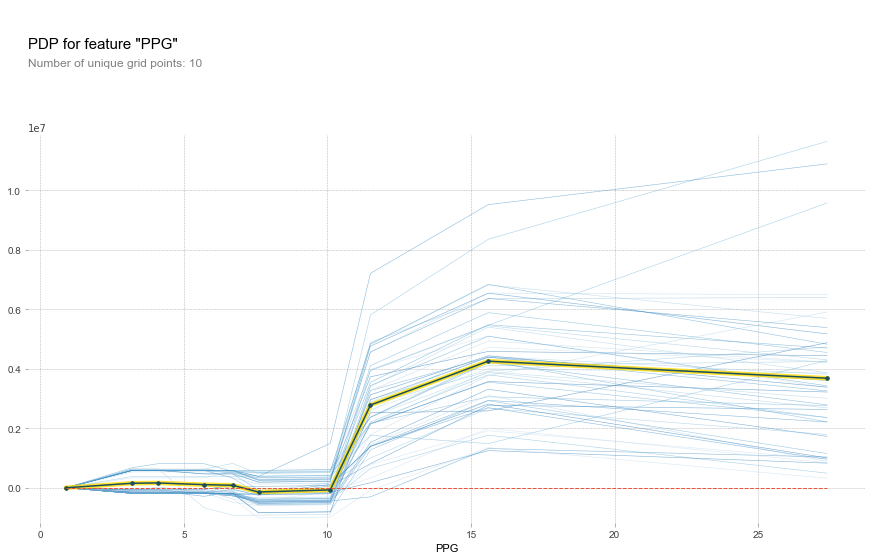

In [26]:
# run PDP plot to analyze
feature = 'PPG'

isolated = pdp_isolate(
    model=xgpipeline, 
    dataset=X_test_imputed, 
    model_features=X_test_imputed.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50); # Plot 100 ICE lines

In [27]:
# shap plot, identify row and row processed
row = X_test.iloc[4]
row_processed = X_test_scaled.iloc[4]

# shap plot, define explainer and shap_values variables
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_processed)

In [28]:
# shap plot, generate plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [84]:
# create new dataframe displaying salary projections for test data
df2 = pd.DataFrame({
    'Player': test_player,
    'actual_sal': y_test.astype(int),
    'pred_sal_xgb': y_pred2.astype(int),
    'xgb_diff': (y_test.astype(int) - y_pred2.astype(int)),
    'pred_sal_lr': y_pred.astype(int),
    'lr_diff': (y_test.astype(int) - y_pred.astype(int)),
})

# create new dataframe displaying salary projections for train data
df3 = pd.DataFrame({
    'Player': train_player,
    'actual_sal': y_train.astype(int),
    'pred_sal_xgb': y_pred4.astype(int),
    'xgb_diff': (y_train.astype(int) - y_pred4.astype(int)),
    'pred_sal_lr': y_pred3.astype(int),
    'lr_diff': (y_train.astype(int) - y_pred3.astype(int)),
})

# merge train/test salary projection dataframes together
df2 = pd.concat([df2, df3], ignore_index=True)

# merge columns from original dataframe to new salary dataframe
df2 = df2.merge(
     df[['Player','Pos','Age', 'Ht(in)',
            'Wt(lbs)', 'MPG', 'FG%', '3P%', 'FT%',
            'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG',
            ]], 
     how='left'
)



# format salary numbers as dollar amounts
# df2['actual_sal'] = df2['actual_sal'].map("\${:,.0f}".format)
# df2['pred_sal_xgb'] = df2['pred_sal_xgb'].map("\${:,.0f}".format)
# df2['xgb_diff'] = df2['xgb_diff'].map("\${:,.0f}".format)
# df2['pred_sal_lr'] = df2['pred_sal_lr'].map("\${:,.0f}".format)
# df2['lr_diff'] = df2['lr_diff'].map("\${:,.0f}".format)

In [30]:
# separate lebron salaries into its own dataframe
lebron = df2.loc[df2['Player'] == 'LeBron James']
lebron = lebron[['actual_sal', 'pred_sal_xgb', 'pred_sal_lr']]

In [94]:
lebron

,actual_sal,pred_sal_xgb,pred_sal_lr
4,35654150,32369626,32095524


In [121]:
a = list(lebron)
b = lebron.iloc[0]

In [120]:
b

actual_sal      35654150
pred_sal_xgb    32369626
pred_sal_lr     32095524
Name: 4, dtype: int64

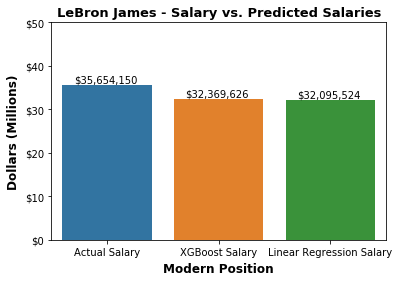

In [129]:
ax = sns.barplot(x=a, y=b)
plt.title('LeBron James - Salary vs. Predicted Salaries',fontsize=13,weight='bold');
ax.set_xticklabels(['Actual Salary', 'XGBoost Salary', 'Linear Regression Salary'])
ax.set_yticklabels(['$0', '$10', '$20', '$30','$40','$50'])
# set axis labels
ax.set_xlabel('Modern Position',fontsize=12,labelpad=5,weight='bold',)
ax.set_ylabel('Dollars (Millions)',fontsize=12,labelpad=5,weight='bold',)
# set y limits of graph
plt.ylim(0,50000000)
# add annotation above each bar
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', (p.get_x()+.1, p.get_height()+500000))

In [34]:
a

['actual_sal', 'pred_sal_xgb', 'pred_sal_lr']

In [35]:
b

actual_sal      35654150
pred_sal_xgb    32369626
pred_sal_lr     32095524
Name: 4, dtype: int64